In [1]:
import fitz

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image
import fitz  # PyMuPDF

def display_pdf_with_bboxes_and_labels(pdf_path, page_no, bboxes, save_as=None):
    """
    Displays a specific page of a PDF with bounding boxes and their labels overlayed.
    Optionally saves the plot to a file.

    Args:
        pdf_path (str): Path to the PDF file.
        page_no (int): The page number to display (1-based index).
        bboxes (list of dict): List of dictionaries with keys:
                               - 'box' (tuple): Bounding box (x0, y0, x1, y1).
                               - 'label' (str): Label to display for the bounding box.
        save_as (str): File path to save the resulting image (e.g., 'output.png').
    """
    if not os.path.isfile(pdf_path):
        raise FileNotFoundError(f"The file '{pdf_path}' does not exist or the path is invalid.")
    
    pdf_document = fitz.open(pdf_path)

    if page_no < 1 or page_no > len(pdf_document):
        raise ValueError(f"Invalid page number {page_no}. PDF has {len(pdf_document)} pages.")

    page = pdf_document[page_no - 1]
    pix = page.get_pixmap()
    img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

    # Overlay the bounding boxes and labels
    for item in bboxes:
        bbox = item['bbox']
        label = item['type']
        x0, y0, x1, y1 = bbox
        width = x1 - x0
        height = y1 - y0
        rect = patches.Rectangle((x0, y0), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Add label near the bounding box
        ax.text(x0, y0 - 5, label, color='white', fontsize=9, backgroundcolor='red')

    ax.axis('off')

    if save_as:
        plt.savefig(save_as, bbox_inches='tight', pad_inches=0)
        print(f"Plot saved as '{save_as}'")
    else:
        plt.show()

In [3]:
class PdfSplitter:
    """
    Class that splits pdf into text and image part using pymupdf
    """
    def __init__(self):
        pass

    def split(self, path):
        file = fitz.open(path)
        return


In [4]:
path = '../data/testdoc.pdf'

In [5]:
def merge_regions(regions, padding=0):
    """
    Merges consecutive regions of the same type into a single region, with optional padding.

    Args:
        regions (list of dict): List of regions with 'type' and 'bbox'.
        padding (int): Padding to apply to the final merged bounding boxes.

    Returns:
        list of dict: Merged regions with padding applied.
    """
    if not regions:
        return []

    merged = [regions[0]]
    for current in regions[1:]:
        last = merged[-1]
        if current["type"] == last["type"]:
            # Merge bounding boxes
            x0 = min(last["bbox"][0], current["bbox"][0])
            y0 = min(last["bbox"][1], current["bbox"][1])
            x1 = max(last["bbox"][2], current["bbox"][2])
            y1 = max(last["bbox"][3], current["bbox"][3])
            last["bbox"] = (x0, y0, x1, y1)
        else:
            merged.append(current)

    # Apply padding to each merged region
    for region in merged:
        if region['type'] == 'text':
            x0, y0, x1, y1 = region["bbox"]
            region["bbox"] = (
                x0 - padding,  
                y0 - padding,  
                x1 + padding,  
                y1 + padding   
            )
    return merged


def extract_and_merge_pdf_content(pdf_path):
    """
    Extracts and merges content regions from a PDF, categorizing them as 'text' or 'image'.

    Args:
        pdf_path (str): Path to the PDF file.

    Returns:
        list of list of dict: List of pages, where each page is a list of merged regions:
                              - 'type': 'text' or 'image'
                              - 'bbox': Bounding box coordinates (x0, y0, x1, y1)
    """
    content_regions = []
    pdf_document = fitz.open(pdf_path)

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        regions = []

        # Extract text blocks
        text_blocks = page.get_text("blocks")  # Returns list of (x0, y0, x1, y1, "text")
        for block in text_blocks:
            bbox = block[:4]  # Extract bounding box
            regions.append({"type": "text", "bbox": bbox, "page": page_num+1})

        # Extract images
        image_list = page.get_images(full=True)
        for img in image_list:
            xref = img  # Adjusted based on your note
            bbox_rect = page.get_image_bbox(xref)
            bbox = (bbox_rect.x0, bbox_rect.y0, bbox_rect.x1, bbox_rect.y1)
            # Check if the bbox is valid
            if bbox and bbox != (1.0, 1.0, -1.0, -1.0):
                regions.append({"type": "image", "bbox": bbox, "page": page_num+1})

        # Sort regions by their top-left corner for correct order
        regions.sort(key=lambda r: (r["bbox"][1], r["bbox"][0]))

        # Merge consecutive regions of the same type
        merged_regions = merge_regions(regions)
        content_regions.append(merged_regions)

    pdf_document.close()
    return content_regions

# Example usage
merged_regions = extract_and_merge_pdf_content(path)

# Print merged regions for the first page
for region in merged_regions[1]:  # First page
    print(region)

{'type': 'text', 'bbox': (54.68092727661133, 56.71198654174805, 562.2036743164062, 614.3699951171875), 'page': 2}


In [8]:
page = 4

Plot saved as '4-image.png'


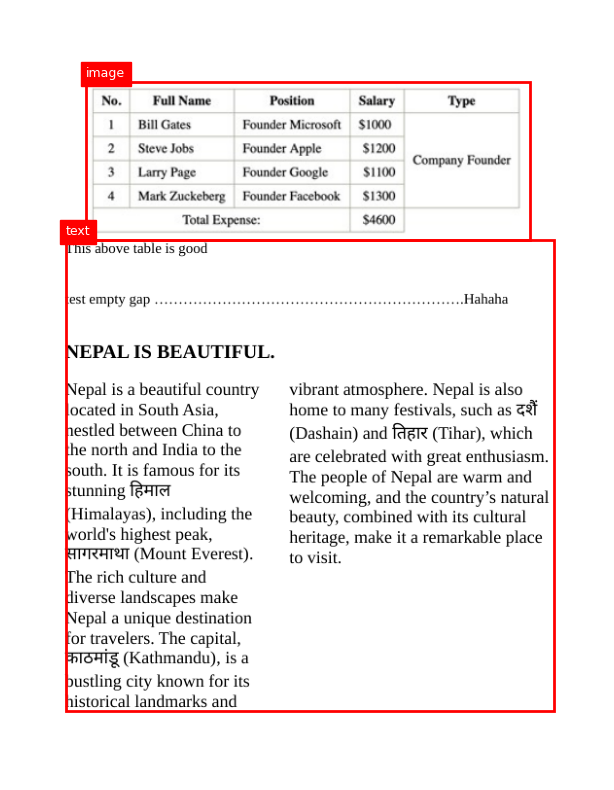

In [9]:
display_pdf_with_bboxes_and_labels(path, page, merged_regions[page-1], f"{page}-image.png")